## Introduction

Computers are (still) getting faster every year and it is now commonplace to run simulations in seconds that would have required hours' or days' worth of compute time in previous generations. That said, we still often come across cases where our computer models are simply too intricate and/or have too many components to run as often and quickly as we would like. In this scenario, we are frequently forced to choose a limited subset of potential scenarios manifest as parameter settings for which we have the resources to run simulations. 

I've written this notebook to show how to use a *statistical emulator* to help understand how the outputs of a model's simulations might vary with parameters. This is going to be similar in many ways to the paper written by Kennedy and O'Hagan (2001) which is frequently cited on the subject, though our approach will be simpler in some regards.

To start us off, I've modified an example of an agent-based model for disease spread on a grid which was written by Damien Farrell on [his personal site](https://dmnfarrell.github.io/bioinformatics/abm-mesa-python). We're going to write a statistical emulator in PyMC3 and use it to infer likely values for the date of peak infection *without* running the simulator exhaustively over the entire parameter space. 

**TL;DR**: we run our simulation for a few combinations of parameter settings and then try to estimate a simulation summary statistic for the entire parameter space.

If you're interested in reproducing this notebook, you can find the `abm_lib.py` file at [this gist](https://gist.github.com/ckrapu/e2fb8692972ec2b499a1494760ff626e).

In [1]:
#from google.colab import drive
import os
import sys
#drive.mount('/content/gdrive')
#sys.path.append('/content/gdrive/MyDrive/abm')
from abmlib import *

In [2]:
import time
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import pickle

from itertools import product, combinations
from functools import partial
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'

save_directory = '../data/'

## Simulating with an ABM

We'll first need to specify the parameters for the SIR model. This model is fairly rudimentary and is parameterized by:
* The number of agents in the simulation 
* The height and width of the spatial grid
* The proportion of infected agents at the beginng
* Probability of infecting other agents in the same grid cell
* Probability of dying from the infection
* Mean + standard deviation of time required to overcome the infection and recover

These parameters, as well as the number of timesteps in the simulation, are all specified in the following cells. I am going to let most of the parameters be fixed as single values - only two parameters will be allowed to vary in our simulations.

In [3]:
fixed_params = {
    "N"            :10000,
    "width"        :60,
    "height"       :20,
    "recovery_sd"  :4,
    "recovery_days":21,
}

For the probability of transmission and death rate, we'll randomly sample some values from the domains indicated below.

In [4]:
sample_bounds = {
    "ptrans"                  : [1e-4, 0.2],
    "death_rate"              : [1e-3, 0.1],
    "pcure"                   : [0.1, 0.99],
    "p_infected_initial_log10": [-4, -2],
    "pdoctor_log10"           : [-4.0, -1.0],

}

pretty_names = {
    'ptrans'                  : 'Transmission probability',
    'death_rate'              : 'Death probability',
    'pcure'                   : 'Cure probability',
    'p_infected_initial_log10': 'Log10 initial infection proportion',
    "pdoctor_log10"           : 'Log10 doctor proportion'
}

reformatted_input_names = [pretty_names[x] for x in sample_bounds.keys()]
sample_vars = list(sample_bounds.keys())

Here, we iteratively sample new values of the parameters and run the simulation. Since each one takes ~40 seconds, it would take too long to run the simulation at every single parameter value in a dense grid of 1000 or more possible settings.

In [5]:
grid_cells = 6
block_size = 100

grids_1d   = []

for k,v in sample_bounds.items():
    grids_1d += [np.linspace(v[0], v[1], grid_cells)]
    
input_dicts = [{k: x[i] for i, k in enumerate(sample_bounds.keys())} for x in product(*grids_1d)]

points            = list(product(*grids_1d))
input_dicts       = [{k: x[i] for i,k in enumerate(sample_bounds.keys())} for x in points]
[x.update(fixed_params) for x in input_dicts]
input_dict_blocks = [input_dicts[i*block_size:(i+1)*block_size] for i in range((int(len(input_dicts)/block_size))+1)]
pickle.dump(input_dicts, open('../data/sir/input_dicts.pkl','wb'))
print(len(input_dicts))

7776


In [ ]:
np.random.seed(827)
run_simulations = True
n_steps         = 80
n_jobs          = 20
save_all_states = False

start = time.time()

def SIR_func(model_kwargs):
        print(f'running with settings {model_kwargs}')
        return SIR(n_steps, model_kwargs=model_kwargs)

for i, block in enumerate(input_dict_blocks):
    doctor_states = all_states = []
    save_dict = {}
    
    print(f'Block {i+1}')
    saved_simulations_path = os.path.join(save_directory, f'saved_simulations_block_{i}.pkl')
    states_save_path = os.path.join(save_directory, f'sir_states_{i}.pkl')
    
    #SIR_func(block[0])
    
    if run_simulations:
        with joblib.parallel_backend(backend='loky', n_jobs=n_jobs):
            simulations = joblib.Parallel()(joblib.delayed(SIR_func)(x) for x in block)
        if save_all_states:
            with open(saved_simulations_path, 'wb') as dst:
                pickle.dump(simulations, dst)
    else:
        with open(saved_simulations_path, 'rb') as src:
            simulations = pickle.load(src)    
    
    all_states    = np.asarray([x[1].astype('int') for x in simulations])
    doctor_states = np.asarray([x[2].astype('int') for x in simulations])
    
    save_dict = {
        'all_states'   :all_states,
        'doctor_states':doctor_states,
        'sample_bounds':sample_bounds,
        'fixed_params' :fixed_params
    }
    with open(states_save_path, 'wb') as dst:
        pickle.dump(save_dict, dst)
        
end = time.time()
print(end - start)

Block 1
Block 2
Block 3
Block 4
Block 5
Block 6
Block 7
Block 8
Block 9
Block 10
Block 11
Block 12
Block 13
Block 14
Block 15
Block 16


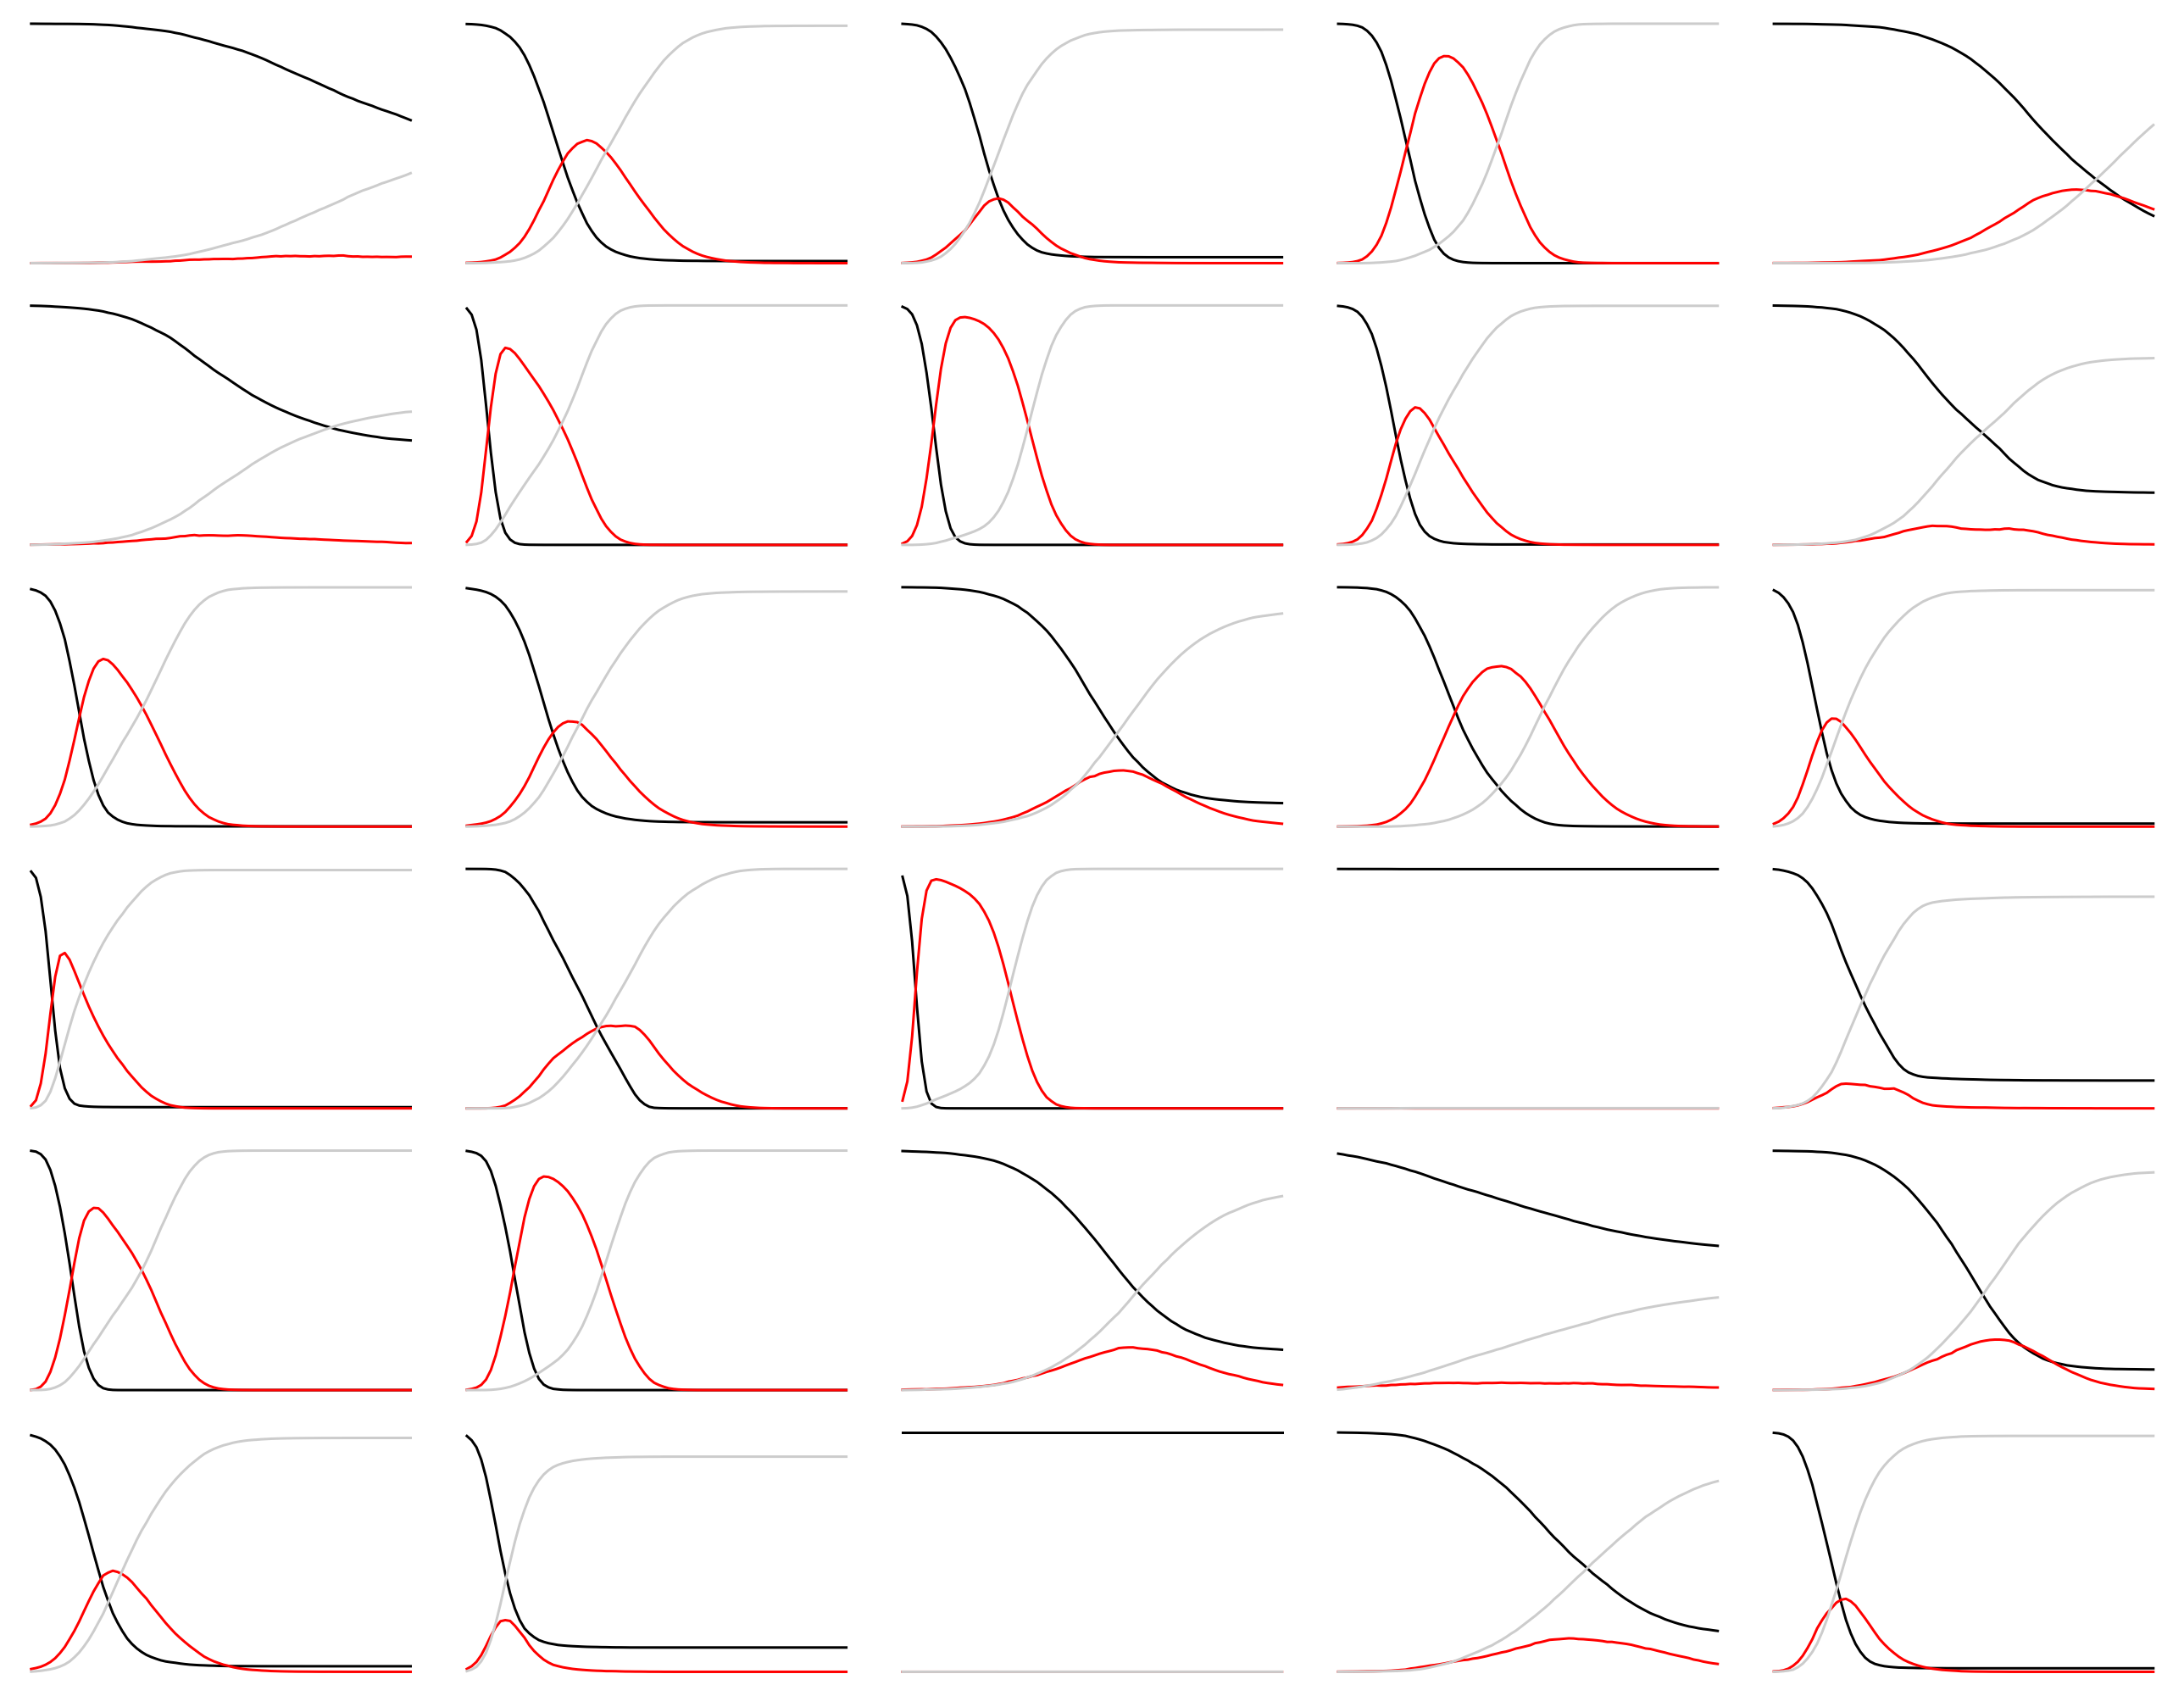

In [ ]:
fig, axes = plt.subplots(6,5, figsize=(18, 14), sharex=True,sharey=True)
colors = ['k', 'r','0.80']
for i, ax in enumerate(axes.ravel()):
    state_sum = all_states[i].sum(axis=(1,2))
    for j in range(3):
        ax.plot(state_sum[:,j], label=['Susceptible','Infected','Removed'],
               color=colors[j])
    ax.axis('off')
    
plt.tight_layout()
plt.savefig(os.path.join(save_directory, 'sir_states.png'))

Next, we combine all the sampled parameter values into a dataframe. We also add a column for our response variable which presents a summary of the results from the ABM simulation. We'll use the timestep for which the level of infection was highest as the `worst_day` column in the dataframe.

In [ ]:
import os
load_from_disk = True

param_filepath = os.path.join(save_directory, 'param_export.csv')

if load_from_disk:
    params_df = pd.read_csv(param_filepath)

else:
    params_df = pd.DataFrame(input_dicts)

    # Add column showing the day with the peak infection rate
    params_df['peak_infection'] = [np.max(x[...,1].sum(axis=(1,2))) for x in all_states]
    params_df['total_removed']  = [x[-1].sum(axis=(0,1))[2] for x in all_states]
    params_df['worst_day']      = [np.argmax(x[...,1].sum(axis=(1,2))) for x in all_states]
    params_df.to_csv(param_filepath)
    
output_vars = ['peak_infection', 'total_removed', 'worst_day']

In [ ]:
params_df[sample_vars + output_vars].head()

,ptrans,death_rate,pcure,p_infected_initial_log10,pdoctor_log10,peak_infection,total_removed,worst_day
0,0.063506,0.026269,0.801222,-3.872699,-1.278393,640.0,7513.0,65
1,0.055568,0.062184,0.129173,-3.021101,-3.596866,10279.0,19826.0,25
2,0.116695,0.050466,0.482748,-3.665243,-1.440527,5412.0,19502.0,20
3,0.081207,0.010703,0.283523,-3.416555,-3.760128,17291.0,19999.0,22
4,0.022151,0.027091,0.241202,-3.141642,-3.093633,6148.0,11535.0,63


Clearly, the model parameters make a major difference in the rate of spread of the virus. In the lower case, the spread requires over 100 timesteps to infect most of the agents.

If we make a plot depicting the date of peak infection as a function of `ptrans` and `death_rate`, we'll get something that looks like the picture below. This is a fairly small set of points and the rest of this notebook will focus on interpolating between them in a way which provides quantified uncertainty.

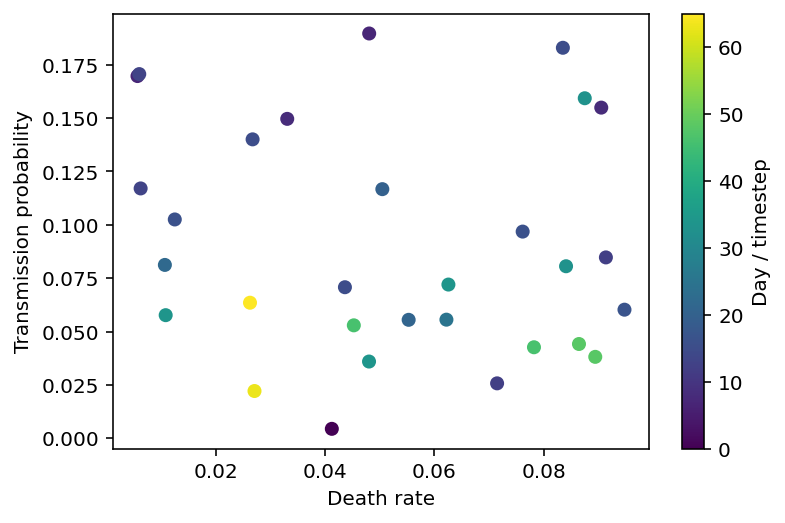

In [ ]:
plt.scatter(params_df.death_rate, params_df.ptrans, c=params_df.worst_day)
plt.xlabel('Death rate'), plt.ylabel('Transmission probability'), plt.colorbar(label="Day / timestep");
